# This is the explorative notebook. We perform basic statistics and do some basic data modeling
## Here are some of the questions we might try to answer:
1. what is the focus of policy documents and what tools do they operationalise? For example, here we looked at a series of laws that deal with adapting to climate change (that is - how do we deal with what's already coming, e.g. extreme weather events) and asked a few questions.
2. what events are the laws focusing on - droughts? floods? hurricanes? wildfires? It's good to know, because it allows a gap analysis of what are some of the unaddressed challenges - if you are prone to floods, you really want a law that sorts out flood barriers and flood insurance, or planning and resource for wildfire prevention and control if you're in a fire risk area.
3. what kind of measures does the document include? are there taxes/subsidies? standards? basically, how does the policy work?

The findings from this are summarised in this policy brief. It was a horrible manual job. The subset of laws analysed here can be found if you filter the dataset to include the word adaptation in the 'framework ' field.


In [1]:
import string
import re
import os
import numpy as np
import pandas as pd

from io import StringIO
from html.parser import HTMLParser

## Define the constants

In [2]:
DATA_DIR = '../data'

## Text preprocessing
### Remove html tags, punctuation, tabulation and special chars.
### Normalize whitespaces

In [3]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.text = StringIO()

    def handle_data(self, d):
        self.text.write(d)

    def get_data(self):
        return self.text.getvalue()

In [4]:
def strip_tags(html):
    s = MLStripper()
    s.feed(str(html))
    return s.get_data()

def remove_tabulations(text):
    text = str(text)
    return(text.replace("\r", ' ').replace("\t", ' ').replace("\n", ' '))

def clean_text(text):
    # Remove HTML tags
    text = strip_tags(text)
    # Remove tabulation
    text = remove_tabulations(text)
    # convert to lower case
    text = text.lower()
    # Remove special characters
    text = re.sub('\[.*?\]', ' ', text)
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # normalize whitespace
    text = ' '.join(text.split())
    return text

def clean_text_basic(text):
    # remove whitespace before and after
    text = text.strip()
    # normalize whitespace
    text = ' '.join(text.split())
    return text

## Read the data

In [5]:
laws_path = os.path.join(DATA_DIR, 'Climate Laws targets-23_03_2021.csv')
events_path = os.path.join(DATA_DIR, 'events-23_03_2021.csv')
legislations_path = os.path.join(DATA_DIR, 'legislations-23_03_2021.csv')

In [6]:
# Add engine 'python' to avoid UnicodeDecodeError, as the cell values are surrounded by double quotes
laws = pd.read_csv(laws_path, sep=',', engine='python')
events = pd.read_csv(events_path, sep=',', engine='python')
legislations = pd.read_csv(legislations_path, sep=',', engine='python')

## Get some basic statistics and show the heads

### Climate laws targets

In [7]:
print("Columns", laws.columns)
print("Shape", laws.shape)

laws.head()

Columns Index(['Id', 'Target type', 'Description', 'Ghg target', 'Year',
       'Base year period', 'Single year', 'Source', 'Geography',
       'Geography iso', 'Sector', 'Connected law ids', 'Scopes',
       'Visibility status'],
      dtype='object')
Shape (2161, 14)


,Id,Target type,Description,Ghg target,Year,Base year period,Single year,Source,Geography,Geography iso,Sector,Connected law ids,Scopes,Visibility status
0,8977,not_applicable,<div>Seaports and airports functioning within ...,False,2030.0,NaN,False,plan,Dominica,DMA,Disaster Risk Management (Drm),9751,NaN,published
1,8976,not_applicable,<div>90% of the population able to identify th...,False,2030.0,NaN,False,plan,Dominica,DMA,Other,9751,NaN,published
2,8975,not_applicable,"<div>100% of national budgeting, policies in p...",False,2030.0,NaN,False,plan,Dominica,DMA,Public Sector,9751,NaN,published
3,8974,not_applicable,<div>50% increase healthy coral reef coverage ...,False,2030.0,NaN,False,plan,Dominica,DMA,Adaptation,9751,NaN,published
4,8973,not_applicable,<div>100% of telecommunications restored withi...,False,NaN,NaN,False,plan,Dominica,DMA,Disaster Risk Management (Drm),9751,NaN,published


In [8]:
laws.isnull().sum()

Id                      0
Target type           767
Description             3
Ghg target              0
Year                  312
Base year period      997
Single year             0
Source                  0
Geography               0
Geography iso           0
Sector                  0
Connected law ids    1131
Scopes                 15
Visibility status       0
dtype: int64

In [9]:
laws['DescriptionClean']=laws['Description'].apply(lambda x: clean_text(x))
laws['NumWords']=laws['DescriptionClean'].apply(lambda x: len(x.split()))

In [10]:
laws.hist(column='NumWords', by='Target type', figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215EEDBE898>,
      dtype=object)

In [11]:
laws.groupby('Target type').agg(['mean', 'median', 'sum', 'std'])['NumWords']

,mean,median,sum,std
Target type,,,,
base_year_target,16.425891,14,8755,10.721029
baseline_scenario_target,23.078947,22,2631,9.680877
fixed_level_target,17.150862,14,7958,11.389571
intensity_target,18.252874,16,1588,7.828419
intensity_target_and_trajectory_target,16.200000,10,81,10.497619
no_document_submitted,1.000000,1,1,NaN
not_applicable,5.638298,2,265,6.706342
trajectory_target,19.167832,16,2741,12.639635


### Climate events

In [12]:
print("Columns", events.columns)
print("Shape", events.shape)

events.head()

Columns Index(['Id', 'Eventable type', 'Eventable', 'Event type', 'Title',
       'Description', 'Date', 'Url'],
      dtype='object')
Shape (2501, 8)


,Id,Eventable type,Eventable,Event type,Title,Description,Date,Url
0,8804,Legislation,1571,Amended,Amended,NaN,20/01/2021,NaN
1,8803,Legislation,1571,Passed/Approved,Approved,NaN,25/10/2010,NaN
2,8802,Legislation,9769,Implementation Details,Guidance on implementation published,NaN,01/07/2020,NaN
3,8801,Legislation,9769,Entered Into Force,Law passed,NaN,28/08/2019,NaN
4,8797,Legislation,9768,Amended,Amended,NaN,12/05/2019,NaN


In [13]:
events.isnull().sum()

Id                   0
Eventable type       0
Eventable            0
Event type           0
Title                0
Description       2481
Date                 0
Url               2501
dtype: int64

In [14]:
events['DescriptionClean']=events['Description'].apply(lambda x: clean_text(x))
events['NumWords']=events['DescriptionClean'].apply(lambda x: len(x.split()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215F3A256D8>,
      dtype=object)

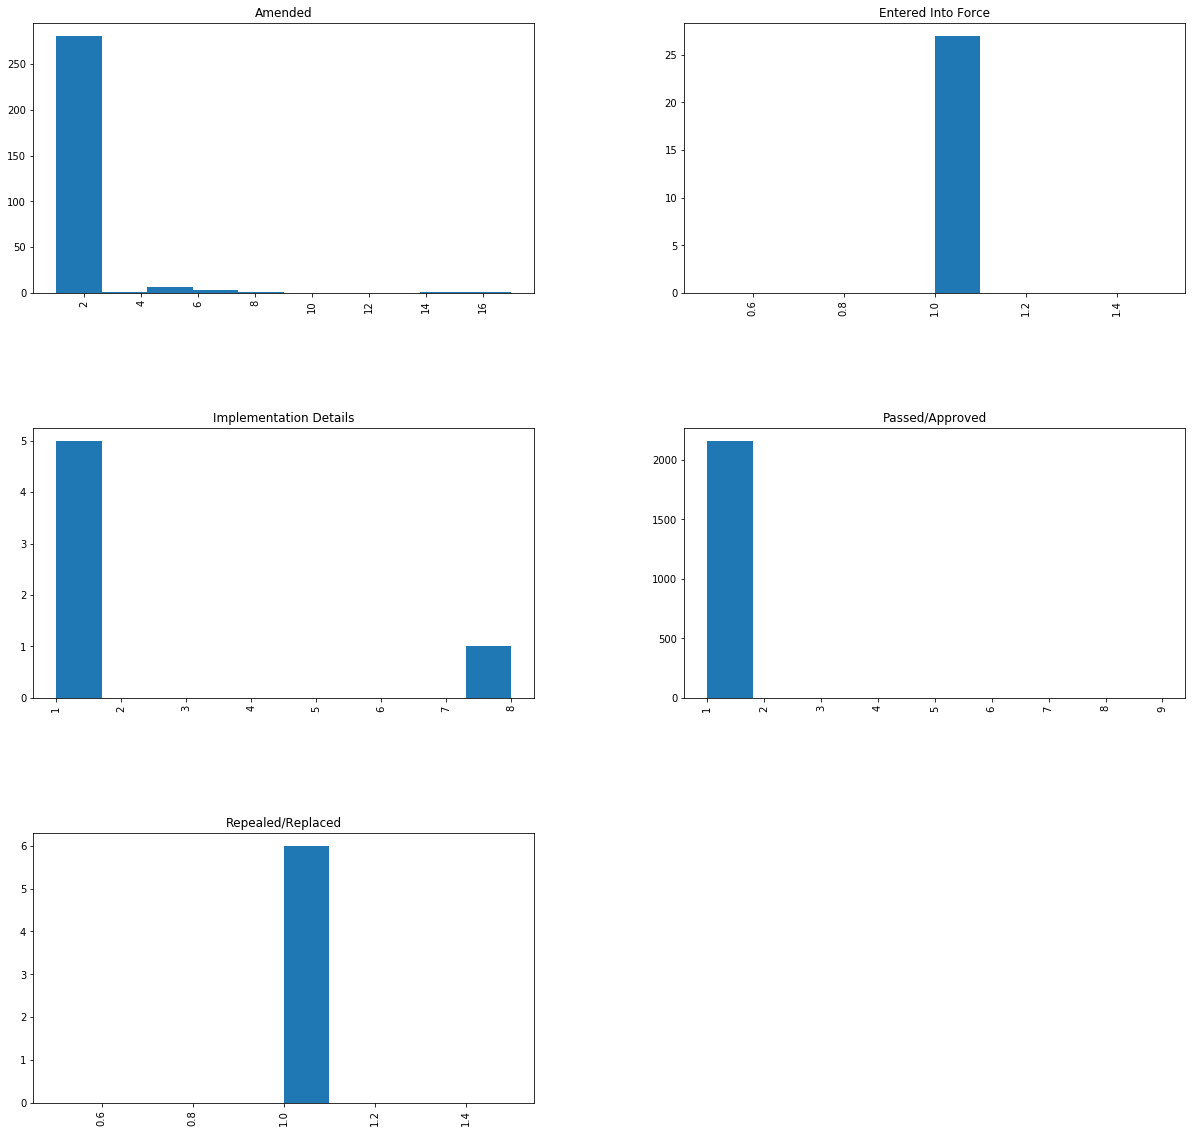

In [15]:
events.hist(column='NumWords', by='Event type', figsize=(20,20))

### Legislations

In [16]:
print("Columns", legislations.columns)
print("Shape", legislations.shape)

legislations.head()

Columns Index(['Id', 'Law Id', 'Title', 'Legislation type', 'Description', 'Parent',
       'Geography', 'Geography iso', 'Sector', 'Frameworks', 'Responses',
       'Document types', 'Keywords', 'Natural hazards', 'Visibility status'],
      dtype='object')
Shape (2128, 15)


,Id,Law Id,Title,Legislation type,Description,Parent,Geography,Geography iso,Sector,Frameworks,Responses,Document types,Keywords,Natural hazards,Visibility status
0,1571,NaN,"Decree-Law No. 117/2010, regulating sustainabi...",executive,<div>This Decree-Law establishes sustainabilit...,2020 Climate and Energy Package (contains Dire...,Portugal,PRT,Energy,NaN,Mitigation,Decree Law,"Institutions / Administrative Arrangements, En...",NaN,published
1,9771,NaN,EU strategy on adaptation to climate change,executive,<div>https://ec.europa.eu/clima/policies/adapt...,NaN,European Union,EUR,NaN,NaN,NaN,NaN,NaN,NaN,pending
2,9769,NaN,Impact Assessment Act,legislative,<div>The Impact Assessment Act of 2019 replace...,NaN,Canada,CAN,Cross Cutting Area,NaN,"Adaptation, Mitigation",Act,Environmental permit,NaN,published
3,8127,NaN,National Climate Change Policy 2015,executive,<div>Mentioned in INDC and other online source...,NaN,Eswatini,SWZ,NaN,"Adaptation, Mitigation",NaN,Policy,"Institutions / Administrative Arrangements, En...",NaN,published
4,9363,NaN,The Climate Act,legislative,<div>The Climate Act sets a target to reduce D...,NaN,Denmark,DNK,Economy-wide,Mitigation,"Adaptation, Mitigation",Act,"Paris Agreement, UNFCCC",NaN,published


In [17]:
legislations.isnull().sum()

Id                      0
Law Id               2128
Title                   0
Legislation type        0
Description             6
Parent               2057
Geography               0
Geography iso           0
Sector                327
Frameworks           1797
Responses             808
Document types         12
Keywords               43
Natural hazards      1919
Visibility status       0
dtype: int64

In [18]:
legislations['DescriptionClean']=legislations['Description'].apply(lambda x: clean_text(x))
legislations['NumWords']=legislations['DescriptionClean'].apply(lambda x: len(x.split()))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000215F44569B0>,
      dtype=object)

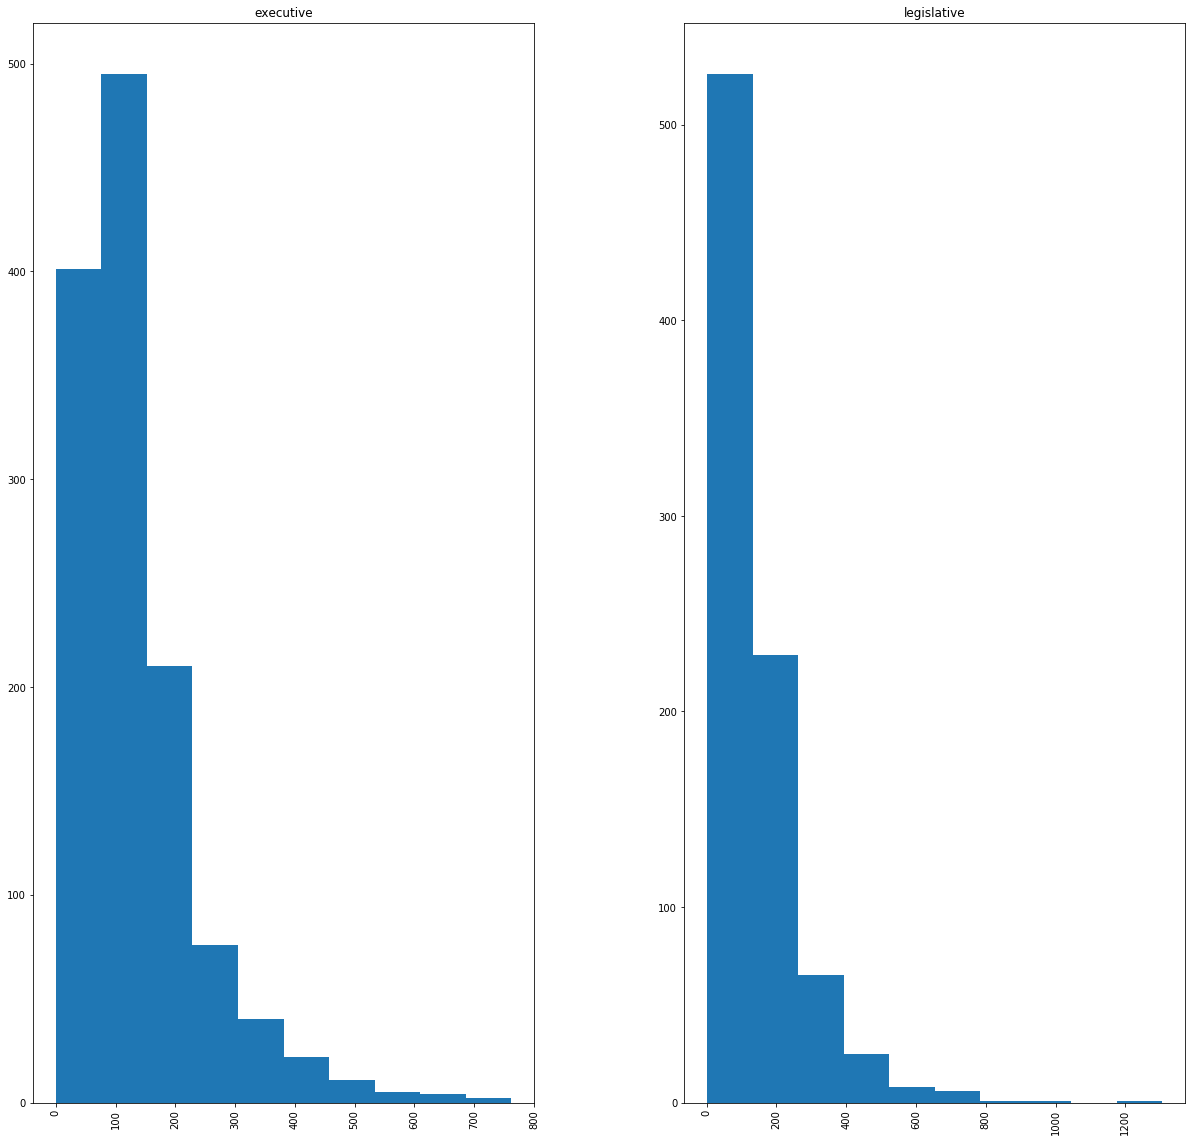

In [19]:
legislations.hist(column='NumWords', by='Legislation type', figsize=(20,20))